![Load Screen](https://img3.svg.com/img/gallery/why-blizzard-wont-release-starcraft-3/blizzards-expansion-model-works-1534974065.jpg)

<h1 style="font-size:30px;">When to Quit; Analyzing Long-Term Match Data Trends in SC2</h1><br>
<i style="font-size:30px;">Theodore Dutcher</i>

Starcraft II (SC2) is a top-down real-time strategy video game where players raise armys and wage war for control over distant star systems. A player picks one of the three science-fiction races (the Terrans, Zerg, and Protoss) then plays one of a variety of gamemodes ranging from single to multiplayer and competitive to casual. The game-mechanics have drawn interest from machine learning projects like Google's AlphaStar. It is a demanding and competitive title with a thriving professional scene.

That being said, in-game data is inaccessable (and very complex). Instead, this tutorial will analyze larger trends across many matches. There are several different opinions amonst the (highly vocal) SC2 playerbase about the optimal length of a play session for those griding their way up the ladder.

    Hypothesis I: Losing streaks make players frustrated and committed, and their odds get worse and worse.
    Hypothesis II: Taking a break from ranked 1v1 games can improve performance in the longterm.
        Hypothesis III.a: This break can be time away from SCII.
        Hypothesis III.b: This break can be a less competitive gamemode.
    Hypothesis III: Winning streaks are punished (disproportionately) by the matchmaking algorithm.

Each of these is testable, and will be addressed over the course of this tutorial. Our approach will be composed of four main steps. First, we will use several old and error-prone APIs to scrape nessesary data. Second, we will compose that data into a useful format (that can answer our questions). Third, we will build and test a model (a decision tree) based on that data that predicts wins and losses. Fourth, we will investigate that model to discover what sorts of play session interventions matter. This is a small(ish) test case, but it illustrates several larger principles of data science. It will also set the mind of this author at ease--letting me waste my time more productively in the future.

In [829]:
# All of the tools used in this tutorial are quite standard.
# The DecisionTreeClassifier will be explained as is needed.

import datetime         # https://docs.python.org/3/library/datetime.html
import time             # https://docs.python.org/3/library/time.html
import re               # https://docs.python.org/3/library/re.html

import requests         # https://pypi.org/project/requests/
import pandas as pd     # https://pandas.pydata.org/index.html
import numpy as np      # https://numpy.org

# https://matplotlib.org/
import matplotlib.pyplot as plt
import graphviz as viz

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier as DTree

<h1 style="font-size:24px;">Part I: API Wrangling</h1>

This class is built to interact with the SC2 API cleanly. The [specifications](https://develop.battle.net/access) of that API can be found online. In short, it allows a user up to 50 clients, each of which is throttled at 100 requests/second and 36000 requests/hour. This class merely authenticates with a battery of client information (saving the token), and switches between clients when one is overloaded. While handy for slimming later code and debugging, it is otherwise unremarkable. Another [tutorial](https://www.dataquest.io/blog/python-api-tutorial/) from the founder of dataquest.io explains the mechancis of this process in more detail.

In [651]:
class requester():
    # Our list of pregenerated client information formated (id, secret, uses).
    clients = [['f6a4bf9a53ff414498b3ec8b9f2c2faf', 'Z6ai38x8iMPgZQa4sh2HCC9LY5XxSMkt', 0],
               ['22b4ddcd94e642c2a6447b848ee9c4ee', '0i62tzntK1y3h7mqo9TlBVtLOKUVg3Kr', 0],
               ['ca72ddb410de4d77a7b9bca93191d50a', 'DFB2c7ClBikC2igNDQaFEd82D0beYtcD', 0],
               ['16521d3c252d42bbb943610a4ceb7e35', '24st4MV1a61XzpmBL4RdcC7wjtRloRzO', 0],
               ['317fd3a86d6c4cf98a9e952c68e5203a', 'lZdAVWC1mVB2ZY6sf3MnC7806jzjONWx', 0]]
    
    active = None # Current client in use.
    token = ''    # Token of active client.
    
    def __init__(self):
        self.activate(0)
        
    
    # Uses active client to make get request.
    def request(self, body):
        if self.clients[self.active][2] > 35999:
            activate(self.active + 1)
        
        headers = {'authorization': 'bearer ' + self.token}
        response = requests.get(body, headers=headers)
        
        if(response.status_code == 429):
            print("Requests arriving too fast. Switching...")
            activate(self.active + 1)
            response = request(body)
            
        self.clients[self.active][2] += 1 # Increment our usage counter.
        return response
        
    # Reautenticates and switches active client.    
    def activate(self, client):
        if client == len(self.clients):
            self.active = 0
        else:
            self.active = client
        
        client_id = self.clients[self.active][0]
        client_secret = self.clients[self.active][1]
        
        # First we request our credentials.
        data = {'grant_type': 'client_credentials'}
        response = requests.post('https://us.battle.net/oauth/token', data=data, auth=(client_id, client_secret))
        
        # Then we extract our access_token.
        pattern = '"access_token":"([A-Za-z0-9]*)"'
        self.token = re.search(pattern, response_client.text)[1]

Now we begin the arduous process of finding lists of seqential games with three essential elements:

    1: Known ownership.
    2: Known gamemode.
    3: Known outcome.
    
We may get a bit of extra data too, but those are the pieces of information essential to answering our question. In order to achive this, however, we have to go through three API layers.

<b>Layer 1</b><br>
Each SC2 league is broken up into a number of ranked ladders of 100 players. These do not serve a mechanical purpose (other than giving players a competitive focus); players play opponents outsider their ladder and may advance without ascending it. Still, the ladder_id of each must be retrieved individually via the League API. The following code finds ladders over current season. For this tutorial, we will only consider the North American Diamond League (a mid-tier and well-populated choice). We will have more than enough data with from this league--any more would needlessly slow us down.

In [652]:
r = requester()

ladder_ids = [] # A ladder_id repository to fill.

# Season 42   |  The latest season.
# Queue 201  |  The 1v1 competitive queue on the latest expansion, Legacy of the Void (LotV).
# Team 0    |  Irrelevant since a team queue was not selected.
# League 4 |  Diamond league, where 25% of the game's playbase resides.

params = {'season': '42', 'queue': '201', 'team': '0', 'league': '4'}
base = 'https://us.api.blizzard.com/data/sc2/league/'
body = base + params['season'] + '/' + params['queue'] + '/' + params['team'] + '/' + params['league']

response = r.request(body)

# Now we just have to navigage the JSON data structure to find every ladder_id.
for ladder in response.json()['tier'][0]['division']:
    ladder_ids += [ladder['ladder_id']]

<b>Layer 2</b><br>
Given that we now have all such ladder_ids, we can find all players in each ladder with the Ladder API. We can also (handily enough) find the time when they entered the ladder. It is unlikely that they would have left it, given that season fourty-two has been progressing for less than a month.

It is now time to make a data structure containing all players in our ladders. We only care about four features of each player for now: their player_id (so we can retrieve match historys), their prefered faction (for later analysis), and when they entered the league (so we can exclude prior games).

In [653]:
player_df = pd.DataFrame(columns=['player_id', 'faction', 'league', 'join_date'])

for ladder_id in ladder_ids:
    
    # Here we make another set of requests, this time getting players in a ladder.
    params = {'region': '1', 'ladder': str(ladder_id)}
    base = 'https://us.api.blizzard.com/sc2/legacy/ladder/'
    body = base + params['region'] + '/' + params['ladder']
    response = r.request(body)

    if(response.status_code == 200):
        members = response.json()['ladderMembers']
        for member in members:
            player_id = member['character']['id']
            
            if 'favoriteRaceP1' in member.keys():
                faction = member['favoriteRaceP1']
            else:
                faction = 'UNKNOWN'
            
            player_df = player_df.append({
                            'player_id': player_id,
                            'faction': faction,
                            'league': 'DIAMOND',
                            'join_date': datetime.datetime.fromtimestamp(member['joinTimestamp'])},
                            ignore_index=True)

In [654]:
player_df.head()

,player_id,faction,league,join_date
0,390389,ZERG,DIAMOND,2019-11-27 02:51:26
1,920320,PROTOSS,DIAMOND,2019-11-29 10:49:12
2,2184664,ZERG,DIAMOND,2019-11-27 02:42:57
3,10771521,TERRAN,DIAMOND,2019-11-27 19:15:30
4,2187241,TERRAN,DIAMOND,2019-11-27 00:06:23


<b>Layer 3</b><br>
Now that we have a list of players and know with a high degree of confidence a period over which they were ranked diamond, we can proceed to the most complex step of our data compilation. We want a list of games, ulimately. We want to know a few things about each: its rank, its outcome, its gamemode, and its data (plus any miscellany we can carry). This is easily achivable with the Match History API.

<h1 style="font-size:24px;">Part II: Data Bending</h1>

This next part, while using APIs, also extends into the next section of our pipeline. More challengingly, we also want to known about all the preceding games. I think we can reasonably settle for five preceding games, however. That should give a good idea of if a player is rusty or honed. It is also sufficient to establish a significant winning or losing streak. Most machine-learning algorithms need a feature space of a known size. Thus we will include with every game data about the outcome, mode, and timing of the five games that came before it (i.e. fiveteen features).

Two problems arise. First, some games may not have give predecesors. Second, the Match History API is notoriously [sparse and fickle](https://us.forums.blizzard.com/en/blizzard/t/startcraft-ll-legacy-api-match-history/372). The API can be trusted to report accruate and precise sequences of games, but only certain stretches. This constitutes data that is mising at random. The properties of interest (i.e. timing, gamemode, ownership) are independant of its disappearance, but it is not missing completely at random because the 'blackouts' are localized in time. In any case, we have enough data to power through all these concerns. Even one league of the North American ladder, we can collect over 20,000 valid games and safely continue with our analysis.

In [655]:
# Each game row contains information about the five before it.
games_stored = 5

# Ties and observers are exceedingly (<0.1%) rare,
# and leaving the game is equivalent to surrender.
# Wins and losses are trues and falses respectively.

outcome_dict = {'Observer': False,
                 'Loss': False,
                 'Left': False,
                 'Tie': True,
                 'Win': True}

# These are dimly ranked from the most competitive solo mode (1v1),
# to the somewhat competitive team modes (2v2, 3v3, 4v4, and Archon Mode),
# to the comparatively uncompetitive modes versus the computer.

mode_dict = {'(Unknown)': 0,
             'Custom': 0,
             'Co-Op': 0,
             'Archon': 1,
             '2v2': 1,
             '3v3': 1,
             '4v4': 1,
             '1v1': 2}

match_df = pd.DataFrame(columns=['player_id', 'faction', 'league', 'outcome', 'mode', 
                                 'date', 'prev_outcomes', 'prev_modes', 'prev_deltas'])

for player in player_df.itertuples(index=False):
    # Recall player data.
    player_id = player[0]
    faction = player[1]
    league = player[2]
    join_date = player[3]
    
    params = {'region': '1', 'realm': '1', 'profile': player_id}
    base = 'https://us.api.blizzard.com/sc2/legacy/profile/'
    body = base + params['region'] + '/' + params['realm'] + '/' + params['profile'] + '/matches'

    response = r.request(body)
    
    # Here we start recovering matches in the relevant time window.
    if(response.status_code == 200):
        matches = response.json()['matches']
        # The matches don't always come sorted (who can say why).
        # We must take care to sort them by datetime timestamp.
        # Their ordering is very important to our data.
        matches = sorted(matches, key=lambda k: datetime.datetime.fromtimestamp(k['date'])) 
        
        # These placeholder varibles are never seen later.
        prev_outcomes = np.zeros(games_stored)
        prev_modes = np.zeros(games_stored)
        prev_deltas = np.zeros(games_stored)
        prev_date = None
        
        valid_matches = 0 # This counter must reach five before we start recording matches.
        
        for match in matches:
            match_date = datetime.datetime.fromtimestamp(match['date'])
            
            if match_date > join_date:
                outcome = outcome_dict[match['decision']]
                mode = mode_dict[match['type']]
                date = match_date
                
                # Find much time has passed.
                if prev_date is None:
                    delta = 0
                else:
                    delta = (match_date - prev_date).total_seconds()
                    
                # Update our time intervals. 
                prev_deltas += delta
                
                # Cycle the time data (since it is the /change/ in time).
                prev_deltas[1:] = prev_deltas[:-1]; prev_deltas[0] = delta
                
                # Since we are already drowning in data, we can ignore the first five matches
                # in a player's history, such that we have clean data with no missing games.
                if valid_matches >= games_stored:
                    match_df = match_df.append({'player_id': player_id,
                                                'faction': faction,
                                                'league': league,
                                                'outcome': outcome,
                                                'mode': mode,
                                                'date': date,
                                                'prev_outcomes': prev_outcomes.copy(),
                                                'prev_modes': prev_modes.copy(),
                                                'prev_deltas': prev_deltas.copy()},
                                               ignore_index=True)
                
                # Remember our date.
                prev_date = date
                
                # Cycle the other data (since it corresponds to the .
                prev_outcomes[1:] = prev_outcomes[:-1]; prev_outcomes[0] = outcome
                prev_modes[1:] = prev_modes[:-1]; prev_modes[0] = mode
                
                # Update our counter.
                valid_matches += 1

In [ ]:
match_df.head()

To make the past conditions searchable, each one needs its own column in a new expanded dataframe. This is generally a good idea when using pandas--it is not designed for values to be lists.

As a note, the above code can take a very long time to run. For the readers's convinience, the expanded dataframe is saved in the same repository as this tutorial (as a pandas-readable .csv).

In [659]:
expanded_df = match_df.copy()

expanded_df = pd.concat((expanded_df, pd.DataFrame.from_records(expanded_df.prev_outcomes, 
                        columns=['o_1', 'o_2', 'o_3', 'o_4', 'o_5'])), axis=1)
                        
expanded_df = pd.concat((expanded_df, pd.DataFrame.from_records(expanded_df.prev_modes, 
                        columns=['m_1', 'm_2', 'm_3', 'm_4', 'm_5'])), axis=1)
                        
expanded_df = pd.concat((expanded_df, pd.DataFrame.from_records(expanded_df.prev_deltas, 
                         columns=['d_1', 'd_2', 'd_3', 'd_4', 'd_5'])), axis=1)

del expanded_df['prev_outcomes']
del expanded_df['prev_modes']
del expanded_df['prev_deltas']

<h1 style="font-size:24px;">Part III: Model Hunting</h1>

For this project, I already have a model in mind. I think a classification decision tree is best suited to this question, and I think you will agree. This is chiefly because it is easy to interogate (especially after prunning). That is to say that, because it functions by making a limited set of binary decisions, its "decision-making process" is comprehensible. It is limited as a predictive model, but since our interest is in implementing data-driven changes in personal behavior, this is largely irrelevant. Lets get our data arranged to use for fitting.

In [662]:
# First we select the last 15 columns of our frame (3 features * 5 times).
X = expanded_df.iloc[:,-15:]

# Then we convert it to a list of numbers.
X = np.array(X.values.tolist())

# Next we select the wins and losses.
y = (expanded_df['outcome']).to_list()

# Then we ensure they are boolean values.
y = np.array(list(map(bool, y)))

There are a lot of different ways to construct a decision tree. I recommend, if your are curious, checking out the work of Blum, Hopcroft, and Kannan in [Foundations of Data Science](https://www.cs.cornell.edu/jeh/book2016June9.pdf) (195-197). The long and short of it is that finding the simplest decision tree for data is very time-consuming. Often, we settle for finding a complex decision tree (that also fits the data). Then we are left with the problem of simplifying it artificially (so-called 'prunning'). This has the benefit of making the tree more explanatory.

Still, before we get there we have to settle on some parameters. Depending on the situtation (i.e. number of features, varience of features, purpose of model) different parameters may be applicable. One obvious example is the <b>max depth</b> of the model. Too low and it will not have the nodes to make all relevant discriminations. Too high and it will overfit, conforming to irrelevant quicks of the training data. Another parameter of interest is how heterogeneous a node must be to split. This threshold, called the <b>minimum impurity decrease</b> directly controls how many leaf nodes will contain wrong answers. Another similar parameter is the <b>max leaf nodes</b>, or how many terminal (i.e. conclusory) nodes can exist in the tree. This directly limits the number of decisions that can be made. Both these last two qualities can improve the interpretability of the model at the expense of its accuracy.

To optimize any of them, we will need a way of testing the models on our training set without overfitting. Here we should use cross validation; part of our data will be withheld while the model trains. Then the model will be tested on the withheld data.

In [666]:
# Note that this function is somewhat adapted from P3. I do not present it as part of the 
# required code for this project, but rather as a function that I need to have to move on.

def cross_validation(k, dtc, X, y):
    # We scramble all indexes of X/y then partition them into k equal chuncks.
    indexes = np.arange(0, len(X))
    np.random.shuffle(indexes)
    partitions = np.array([indexes[i * int(len(X)/k):(i + 1) * int(len(X)/k)] for i in range(k)])
    
    output_a = 0
    output_b = 0
    # In each iteration, all but one chunck is used for training (the remainer is held out for analysis).
    for i, _ in enumerate(partitions):
        holdout = partitions[i]
        training = np.append(partitions[:i], partitions[(i+1):])
                  
        dtc.fit(X[training], y[training])
        score = dtc.score(X[holdout], y[holdout])
        
    return score

In [805]:
scores_df = pd.DataFrame(columns=['threshold 0.0001 | 25 leaves', 'threshold 0.001 | 25 leaves', 'threshold 0.01 | 25 leaves',
                                  'threshold 0.0001 | ? leaves', 'threshold 0.001 | ? leaves', 'threshold 0.01 | ? leaves'])

for depth in range(1,80):
    scores_df = scores_df.append({
        'threshold 0.0001 | 25 leaves': cross_validation(3, DTree(max_depth=depth, min_impurity_decrease=0.0001, max_leaf_nodes=25), X, y),
        'threshold 0.001 | 25 leaves': cross_validation(3, DTree(max_depth=depth, min_impurity_decrease=0.001, max_leaf_nodes=25), X, y),
        'threshold 0.01 | 25 leaves': cross_validation(3, DTree(max_depth=depth, min_impurity_decrease=0.01, max_leaf_nodes=25), X, y),
        'threshold 0.0001 | ? leaves': cross_validation(3, DTree(max_depth=depth, min_impurity_decrease=0.0001), X, y),
        'threshold 0.001 | ? leaves': cross_validation(3, DTree(max_depth=depth, min_impurity_decrease=0.001), X, y),
        'threshold 0.01 | ? leaves': cross_validation(3, DTree(max_depth=depth, min_impurity_decrease=0.01), X, y)},
         ignore_index = True)

Fig. 1


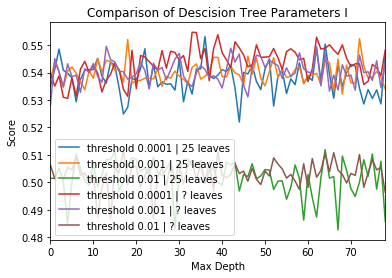

In [806]:
ax = scores_df.plot(title='Comparison of Descision Tree Parameters I')
plt.xlabel("Max Depth")
plt.ylabel("Score")
print('Fig. 1')

<i>Fig. 1: This looks promising, and shows we can accept a minimum impurity decrease of 0.001 without issue.</i>

In [807]:
scores_df = pd.DataFrame(columns=['threshold 0.001 | 10 depth'])

for leaves in range(2,30):
    scores_df = scores_df.append({'threshold 0.001 | 10 depth': 
                                  cross_validation(3, DTree(max_depth=10,
                                  min_impurity_decrease=0.001,
                                  max_leaf_nodes=leaves), X, y)}, ignore_index=True)

Fig. 2


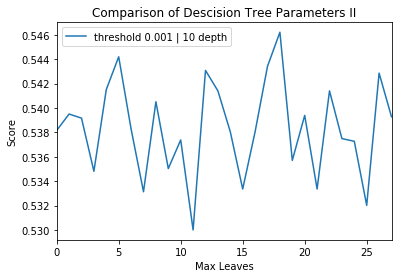

In [808]:
ax = scores_df.plot(title='Comparison of Descision Tree Parameters II')
plt.xlabel("Max Leaves")
plt.ylabel("Score")
print('Fig. 2')

<i>Fig. 2: This varys a little wildly, so we should probably do some averaging.</i>

In [809]:
scores_df = pd.DataFrame(columns=['threshold 0.001 | 10 depth'])

for leaves in range(2,30):
    scores_df = scores_df.append({'threshold 0.001 | 10 depth': np.mean([cross_validation(3, DTree(max_depth=10,
                                                                min_impurity_decrease=0.001,
                                                                max_leaf_nodes=leaves, random_state=x), X, y)
                                                                for x in range(10)])}, ignore_index=True)

Fig. 3


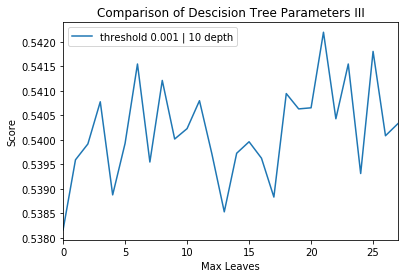

In [810]:
ax = scores_df.plot(title='Comparison of Descision Tree Parameters III')
plt.xlabel("Max Leaves")
plt.ylabel("Score")
print('Fig. 3')

<i>Fig. 3: There does seem to be a fairly consistent peak around leaves = [3, 5].</i>

We now have enough parameters nailed down to construct a model. So its seems as though our decision tree cares little about its max depth (it will overfit, but not become stronger). As long as the threshold (min_impurity_decrease) is below 0.01 and the leaves are a little over zero model performance seems to chage little. As such we should adopt the simplest model. Also note that the maximum model score is only ~0.55. This is not very good in general, but it is reasonable for us because we are looking at <i>largely</i> unrelated data. If a previous match could fully predict a future match, it would not be a good game. The fact that the model does not benefit from more depth & leaves is indicitive of the fact that it is not making many decisions. In a way this is good--it means the tree will be interpretable.

In [ ]:
dtc = DTree(max_depth=5, min_impurity_decrease=0.001, max_leaf_nodes=4)
dtc = dtc.fit(X, y)

![Crusiers](http://s1.picswalls.com/wallpapers/2014/06/22/beautiful-starcraft-wallpaper_105913738_46.jpg)

<h1 style="font-size:24px;">Part IV: Weaving Conclusions</h1>

Given that we have our model, as clean and predictive as it is likely to get, we need to look at the decisions it is making. First we will examine what characteristics are important with a heat map.

Fig. 4


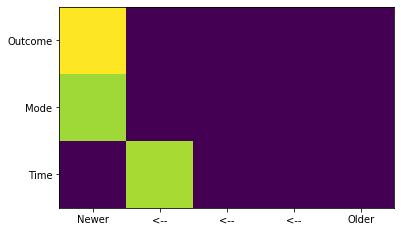

In [802]:
bottom = ['Newer', '<--', '<--', '<--', 'Older']
side = ['Outcome', 'Mode', 'Time']
importances = dtc.feature_importances_.reshape(3,5)

fig, ax = plt.subplots()
im = ax.imshow(importances)
ax.set_xticks(np.arange(len(bottom)))
ax.set_yticks(np.arange(len(side)))
ax.set_xticklabels(bottom)
ax.set_yticklabels(side)
print('Fig. 4')


<i>Fig. 4: The most important data comes from the outcome of the last game, but the mode of the last game and the timing of the game before that are also used.

This is interesting, but it inspires confidence in the model that the most predictive elements are the most recent (the model has no good way of knowning that). It is not entirely surprising that the timing of past days may be relevant. Low values in spots corresponding to the second, third, or fourth most recent games would strongly indicate lots of back-to-back games.

In [838]:
dot_data = sklearn.tree.export_graphviz(dtc, out_file=None) 
graph = viz.Source(dot_data).view()

Fig. 5
![Graph](https://i.imgur.com/Rn6bFBf.jpg)

<i> Fig. 5: X[0] is the most recent match outcome. X[5] is the most recent match mode. X[11] is the time since the second-to-last match.</i>

This is a result greatly satisfying in its simplicity. If the last game was lost, it checks to see if the second to last game was played very recently. If it was, then it gives an abysmal chance of success: 17%. Otherwise, even despite the last game being lost, the chance of victory hovers around 50%. On the other hand, if the last game was won, it looks to see what the type of it was. If it was a competitive 1v1, then the chance of victory is again 50%. Otherwise, if it was a custom game or team game, the chance of victory lowers significantly to 46%.

If I were to extrapolate from this, I think the left-most node is pulling out a very specific (if not very large, with a sample size of 274) subgroup of people who validate Hypothesis I and Hypothesis II. The time cut off is 274 seconds--about five minutes. That means the person has played two consecutive short games, which is probably indicitive of agressive and gimmicky tactics. On the other hand, people who do not play so quickly and take a longer time between matches seem to do far better.

Secondarily, the existance of the right-most node seems like a significant blow to Hypothesis III. Players who have just won a competitive game are at no disadvantage in the next match--their odds remain even. Consider my faith in the matchmaking algorithm fortified.

There is definitely more work that could be done with this dataset, but together I think the main goal was accomplished. Here we worked over our parameters until we got down to the simplest model that captured the essence of the problem. That model, I would say, has done an excellent job of shedding light on our original questions.